In [1]:
from utils import *

In [29]:
points_msg=rospy.wait_for_message("/hsrb/head_rgbd_sensor/depth_registered/rectified_points",PointCloud2,timeout=5)
points_data = ros_numpy.numpify(points_msg)    
image_data = points_data['rgb'].view((np.uint8, 4))[..., [2, 1, 0]]   
image=cv2.cvtColor(image_data, cv2.COLOR_BGR2RGB)
image = points_data['rgb'].view((np.uint8, 4))[..., [2, 1, 0]]
    #hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV_FULL)
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
print (image.shape)

(480, 640, 3)


In [30]:
_,corrected=correct_points(points_msg)


############head [ 9.90209442 -1.54824593  0.98045538] [ 0.84313196 -0.08186409  0.05135861 -0.52895091]


In [31]:
import matplotlib.pyplot as plt
%matplotlib inline


In [32]:
corrected['z'].shape

(480, 640)

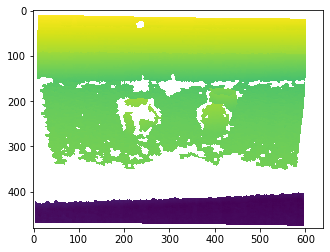

In [33]:
plt.imshow(corrected['z'])

In [34]:
zs_no_nans=np.zeros((corrected['z'].shape))
for i in range(corrected['z'].shape[0]):
    for j in range(corrected['z'].shape[1]):
        if np.isnan(corrected['z'][i,j]):
            zs_no_nans[i,j]=1.0
            #print ('reject')
        else:
            zs_no_nans[i,j]=corrected['z'][i,j]
# SUGERENCIA             
#zs_no_nans=np.where(~np.isnan(corrected['z']),corrected['z'],1)

In [35]:
zs_no_nans

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [36]:
#correspondencia de valores

In [37]:
zs_no_nans[300,300]

-0.29408612847328186

In [38]:
histogram, bin_edges =(np.histogram(zs_no_nans, bins=50))

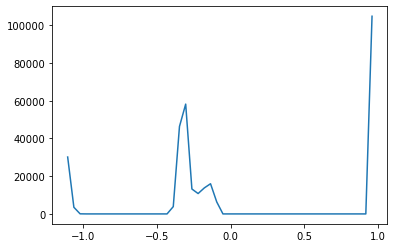

In [39]:
plt.plot(bin_edges[0:-1], histogram)  

In [40]:
histogram[:-1].argmax(), bin_edges[histogram[:-1].argmax()]

(19, -0.3033994221687317)

In [41]:
bin_edges[histogram[:-1].argmax()+1]   ## Most repeated z's sould be a plane (pararlel to floor)
### it is  approx 40cms beneath de sensor ( z=-0.40m)

-0.2613542795181275

In [42]:
t = tfBuffer.lookup_transform('map', 'head_rgbd_sensor_link', rospy.Time())
trans=t.transform.translation.z


In [43]:
img_corrected = np.where((-zs_no_nans < trans*0.99) ,zs_no_nans,5.0)  #FLOOR


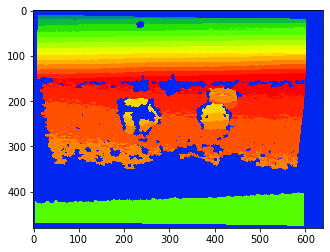

In [44]:
plt.imshow(img_corrected, cmap='prism')

In [45]:
img_corrected[300,30], zs_no_nans[300,30]

(1.0, 1.0)

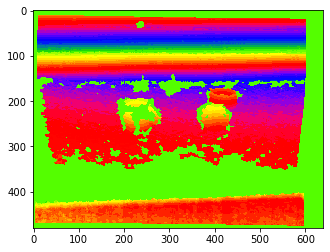

In [46]:
plt.imshow(zs_no_nans, cmap='prism')

In [47]:
plane_height= (trans)+bin_edges[histogram[:-1].argmax()+1]
(trans*0.999)-0.705, (trans*0.999)-plane_height


(0.27447487299451645, 0.2603738241898047)

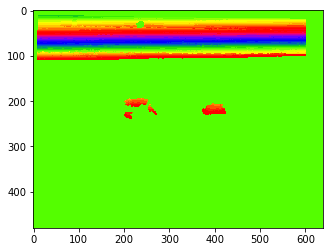

In [48]:
#img_corrected = np.where(    (-zs_no_nans <  (trans*0.999)-0.705  )                         ,zs_no_nans,1)  # ver celda de arriba de donde salio este numero
img_corrected = np.where(    (-zs_no_nans <  (trans*0.999)-plane_height-.01  )                         ,zs_no_nans,1)  # ver celda de arriba de donde salio este numero
plt.imshow(img_corrected, cmap='prism')

In [49]:
img_corrected[100,600],img_corrected[100,300]

(-0.2479366660118103, -0.2384006232023239)

In [50]:
img_corrected[300,300], zs_no_nans[300,300]

(1.0, -0.29408612847328186)

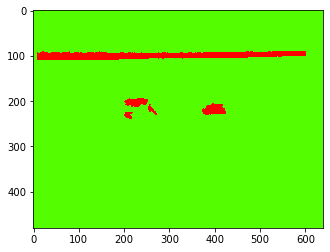

In [51]:
#table1#img_corrected_top = np.where(    (-img_corrected >  (trans*0.999)-0.751  ) ,img_corrected,1)
img_corrected_top = np.where(    (-img_corrected >  (trans*0.999)-0.77 )                        ,img_corrected,5)
## REFERENCIA
plt.imshow(img_corrected_top, cmap='prism')

In [52]:
img_corrected[300,300], zs_no_nans[300,300]

(1.0, -0.29408612847328186)

In [53]:
(trans*0.999)-0.751

0.2284748729945164

In [54]:
lower=100
higher=200000
reg_ly= 30
reg_hy=600
contours, hierarchy = cv2.findContours(img_corrected.astype('uint8'),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
i=0
cents=[]
points=[]
images=[]
for i, contour in enumerate(contours):

    area = cv2.contourArea(contour)
    if area > lower and area < higher :
        M = cv2.moments(contour)
        # calculate x,y coordinate of center
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
        if (cY > reg_ly and cY < reg_hy  ):

                boundRect = cv2.boundingRect(contour)
                #just for drawing rect, dont waste too much time on this
                #image_aux= iimmg[boundRect[1]:boundRect[1]+max(boundRect[2],boundRect[3]),boundRect[0]:boundRect[0]+max(boundRect[2],boundRect[3])]
                

                image_aux= image[boundRect[1]:boundRect[1]+boundRect[3],boundRect[0]:boundRect[1]+boundRect[2]]
                images.append(image_aux)
                image_aux= img_corrected[boundRect[1]:boundRect[1]+boundRect[3],boundRect[0]:boundRect[0]+boundRect[2]]

                mask=np.where(image_aux!=5)
                npmask=np.asarray(mask).T
                hsv_image=cv2.rectangle(hsv_image,(boundRect[0], boundRect[1]),(boundRect[0]+boundRect[2], boundRect[1]+boundRect[3]), (0,0,0), 2)
                cv2.circle(hsv_image, (cX, cY), 5, (255, 255, 255), -1)
                cv2.putText(hsv_image, "centroid_"+str(i)+"_"+str(cX)+','+str(cY)    ,    (cX - 25, cY - 25)   ,cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 0), 2)
                print ('cX,cY',cX,cY,'len mask',len(npmask))
                

cX,cY 209 230 len mask 391
cX,cY 261 219 len mask 572
cX,cY 399 218 len mask 1710
cX,cY 227 202 len mask 1265
cX,cY 295 60 len mask 60792
cX,cY 236 31 len mask 288


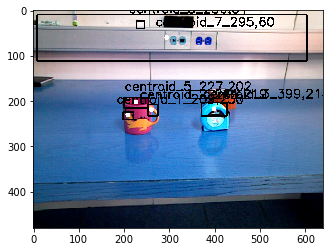

In [55]:
plt.imshow(hsv_image)

In [ ]:
corrected['x'][]